In [36]:
import pandas as pd
import numpy as np

### Load datase

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv")

In [3]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


### Data Preparation

In [4]:
### Check if the missing values are presented in the features
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [7]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [10]:
### For categorical features, replace them with 'NA'
#lead_source, industry, employment_status, location
df.lead_source = df.lead_source.fillna('NA')
df.industry = df.industry.fillna('NA')
df.employment_status = df.employment_status.fillna('NA')
df.location =  df.location.fillna('NA')

In [11]:
### For numerical features, replace with with 0.0
# number_of_courses_viewed, interaction_count, annual_income, lead_score, converted
df.annual_income = df.annual_income.fillna(0.0)

### Question 1
What is the most frequent observation (mode) for the column industry?

In [12]:
mode_industry = df['industry'].mode()[0]

In [13]:
mode_industry

'retail'

### Question 2
Create the correlation matrix for the numerical features of your dataset. In a correlation matrix, you compute the correlation coefficient between every pair of features.

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [19]:
numerical_features = ['number_of_courses_viewed', 'interaction_count', 'annual_income', 'lead_score']

In [20]:
num_df = df[numerical_features]

In [21]:
corr_matrix = num_df.corr()
print(corr_matrix)

                          number_of_courses_viewed  interaction_count  \
number_of_courses_viewed                  1.000000          -0.023565   
interaction_count                        -0.023565           1.000000   
annual_income                             0.009770           0.027036   
lead_score                               -0.004879           0.009888   

                          annual_income  lead_score  
number_of_courses_viewed       0.009770   -0.004879  
interaction_count              0.027036    0.009888  
annual_income                  1.000000    0.015610  
lead_score                     0.015610    1.000000  


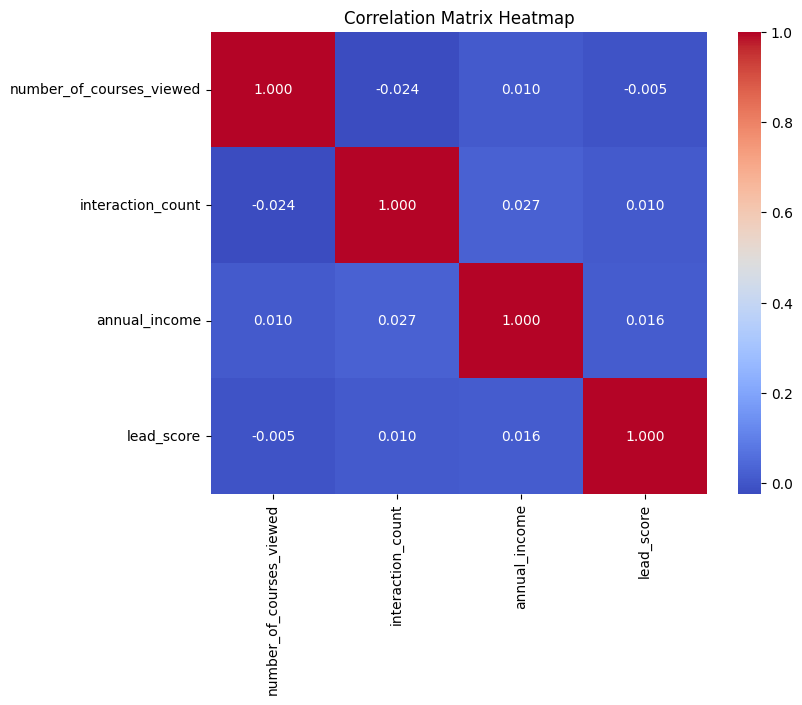

In [23]:
corr_matrix = num_df.corr()

# Create Plot
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".3f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix Heatmap")
plt.show()


#### Split the data
Split your data in train/val/test sets with 60%/20%/20% distribution.

In [79]:
target = 'converted'
y = df[target]
X = df.drop(columns=[target]) 

In [80]:
# Revisar shapes
print(X.shape, y.shape)

(1462, 8) (1462,)


In [137]:
# Split the DataFrame into training and temporary sets.
# The temporary set will later be split into validation and test sets.
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

In [138]:
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [38]:
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

### Question 3
Calculate the mutual information score between converted and other categorical variables in the dataset. Use the training set only.
Round the scores to 2 decimals using round(score, 2).

In [56]:
from sklearn.metrics import mutual_info_score

In [63]:
categorical_features = ['lead_source', 'industry', 'employment_status', 'location']

In [57]:
#Categorical features: lead_source, industry, employment_status, location
mutual_info_score(y_train.converted, X_train.lead_source)

0.02716126886055452

In [58]:
mutual_info_score(y_train.converted, X_train.industry)

0.013787922374953562

In [59]:
mutual_info_score(y_train.converted, X_train.employment_status)

0.007115060125764211

In [60]:
mutual_info_score(y_train.converted, X_train.location)

0.0013465104317706492

In [67]:
def mutual_info_converted_score(series):
    return mutual_info_score(series, y_train.converted)

In [68]:
mi = X_train[categorical_features].apply(mutual_info_converted_score)
mi.sort_values(ascending=False)


lead_source          0.027161
industry             0.013788
employment_status    0.007115
location             0.001347
dtype: float64

In [69]:
round(mi.sort_values(ascending=False), 2)

lead_source          0.03
industry             0.01
employment_status    0.01
location             0.00
dtype: float64

### Question 4
Now let's train a logistic regression.

In [121]:
from sklearn.feature_extraction import DictVectorizer

In [163]:
dv = DictVectorizer(sparse=False)

train_dict = X_train[categorical_features + numerical_features].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = X_val[categorical_features + numerical_features].to_dict(orient='records')
X_val = dv.transform(val_dict)

#### Fit the model on the training dataset.
    To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)

In [123]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [124]:
# Create the model with the given parameters
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)

In [125]:
# Fit the model on the training data
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [126]:
# Make predictions on the validation set
y_pred = model.predict(X_val)

In [127]:
# Calculate the accuracy
acc_original = accuracy_score(y_val, y_pred)

# Round to 2 decimal places
accuracy_rounded = round(acc_original, 2)

In [128]:
print("Accuracy on validation set:", accuracy_rounded)

Accuracy on validation set: 0.68


### Question 5
Let's find the least useful feature using the feature elimination technique.
Train a model using the same features and parameters as in Q4 (without rounding).
Now exclude each feature from this set and train a model without it. Record the accuracy for each model.
For each feature, calculate the difference between the original accuracy and the accuracy without the feature.


In [155]:
def find_least_useful_feature(X_train, y_train, X_val, y_val, features, accuracity, categorical_features, numerical_features):
    diff_dict = {}
    for feature in features:

        X_train_new_df = X_train.drop(columns=[feature])
        X_val_new_df = X_val.drop(columns=[feature])

        new_categorical = [f for f in categorical_features if f != feature]
        new_numerical = [f for f in numerical_features if f != feature]

        dv_tmp = DictVectorizer(sparse=False)
        train_dict_tmp = X_train_new_df[new_categorical + new_numerical].to_dict(orient='records')
        X_train_new = dv_tmp.fit_transform(train_dict_tmp)

        val_dict_tmp = X_val_new_df[new_categorical + new_numerical].to_dict(orient='records')
        X_val_new = dv_tmp.transform(val_dict_tmp)

        model_tmp = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
        model_tmp.fit(X_train_new, y_train)

        # Accuracy
        y_pred_tmp = model_tmp.predict(X_val_new)
        acc_without_feature = accuracy_score(y_val, y_pred_tmp)

        diff_dict[feature] = acc_original - acc_without_feature

    # Feature with less impact
    least_useful = min(diff_dict, key=lambda k: abs(diff_dict[k]))

    return least_useful, diff_dict

In [156]:
features = ['lead_source', 'industry', 'employment_status', 'location']

In [157]:
least_useful, diffs = find_least_useful_feature(X_train, y_train, X_val, y_val, features, acc_original, categorical_features, numerical_features)

In [158]:
least_useful, diffs

('employment_status',
 {'lead_source': 0.010273972602739656,
  'industry': -0.006849315068493178,
  'employment_status': 0.0,
  'location': -0.006849315068493178})

### Question 6
Now let's train a regularized logistic regression.
Let's try the following values of the parameter C: [0.01, 0.1, 1, 10, 100].
Train models using all the features as in Q4.
Calculate the accuracy on the validation dataset and round it to 3 decimal digits.

In [164]:
def train_logistic_regression_reg(X_train, y_train, X_val, y_val):
    C_values = [0.01, 0.1, 1, 10, 100]

    results = {}
    
    for C in C_values:
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=42)
        model.fit(X_train, y_train)
    
        y_pred = model.predict(X_val)

        acc = accuracy_score(y_val, y_pred)
        results[C] = round(acc, 3) 
    
    best_C = max(results, key=results.get)
    return results, best_C

In [165]:
res = train_logistic_regression_reg(X_train, y_train, X_val, y_val)

In [166]:
res

({0.01: 0.688, 0.1: 0.682, 1: 0.682, 10: 0.682, 100: 0.682}, 0.01)